In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
# from joblib import dump
import joblib
import warnings
import statsmodels.api as sm
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import wandb
warnings.filterwarnings('ignore')
# import dask.dataframe as dd


d:\ads_enfit\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exps_dir = "../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [3]:
style_dir='../../../styles'
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [4]:
# wandb.init(project="enefit_prediction_consumer")


In [5]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [7]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


lr = 0.0001


features = len(X_train.columns)



# Khởi tạo mô hình Sequential
model = Sequential()

model.add(Conv1D(32, 3, activation='relu', input_shape=(features, 1)))

model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))



# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mae', metrics=['mae',r2])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,649 (404.88 KB)

 Trainable params: 103,649 (404.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_cnn.keras',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    # save_format="tf"
)

In [10]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16972/16982 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4666 - mae: 0.4666 - r2: -12.9049
Epoch 1: val_loss improved from inf to 0.42153, saving model to best_model_cnn.keras
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 92s 5ms/step - loss: 0.4665 - mae: 0.4665 - r2: -12.8972 - val_loss: 0.4215 - val_mae: 0.4215 - val_r2: 0.3302 - learning_rate: 1.0000e-04
Epoch 2/10000
16980/16982 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2203 - mae: 0.2203 - r2: 0.6017
Epoch 2: val_loss improved from 0.42153 to 0.23512, saving model to best_model_cnn.keras
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - loss: 0.2203 - mae: 0.2203 - r2: 0.6017 - val_loss: 0.2351 - val_mae: 0.2351 - val_r2: 0.4364 - learning_rate: 1.0000e-04
Epoch 3/10000
16980/16982 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1765 - mae: 0.1765 - r2: 0.6947
Epoch 3: val_loss did not improve from 0.23512
16982/16982 ━━━━━━━━━━━━━━━━━━━━ 90s 5ms/step - loss: 0.1765 - mae: 0.1765 - r2: 0.6947 - val_loss: 0.9723 - val_mae: 0.9723 - val_r

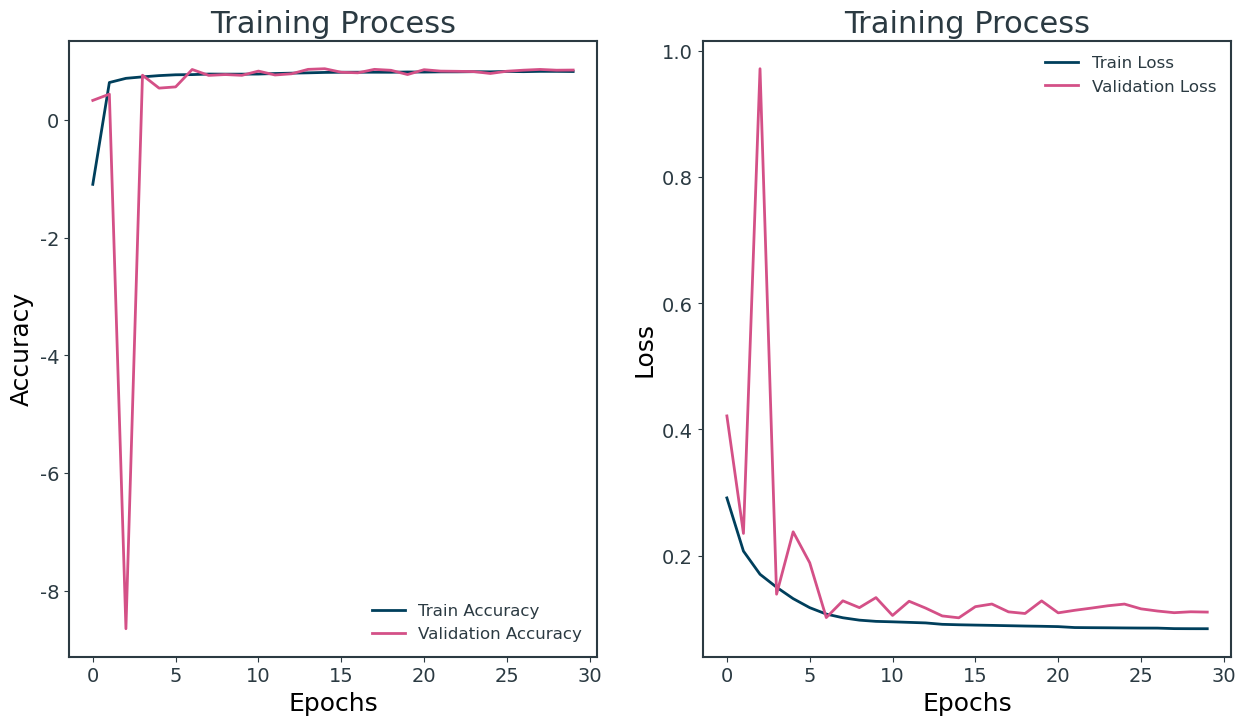

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [12]:
model.history.history['r2']

[-1.0948171615600586,
 0.6339511871337891,
 0.7048748135566711,
 0.7298996448516846,
 0.7512028813362122,
 0.7652477622032166,
 0.7682992815971375,
 0.777513861656189,
 0.7760119438171387,
 0.775941014289856,
 0.777500331401825,
 0.7867012619972229,
 0.7927969694137573,
 0.7984176278114319,
 0.8052160143852234,
 0.8083100318908691,
 0.8088226318359375,
 0.8086695075035095,
 0.8082048892974854,
 0.8129565715789795,
 0.8113731741905212,
 0.8150126338005066,
 0.815216600894928,
 0.8178724646568298,
 0.8155273199081421,
 0.8222883939743042,
 0.8180453777313232,
 0.8234103322029114,
 0.8230969309806824,
 0.820744514465332]

In [13]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'learning_rate'])
[0.2914588451385498, 0.20706181228160858, 0.1703338474035263, 0.14976608753204346, 0.13169747591018677, 0.11737427115440369, 0.10719913989305496, 0.10136165469884872, 0.09756258130073547, 0.09563601762056351, 0.09490497410297394, 0.09404700994491577, 0.09317728132009506, 0.09093982726335526, 0.09022187441587448, 0.08971936255693436, 0.08926142752170563, 0.0887499749660492, 0.0882367268204689, 0.08783090114593506, 0.08730696141719818, 0.08582358807325363, 0.08560119569301605, 0.08544109016656876, 0.08520299196243286, 0.08503368496894836, 0.08494248986244202, 0.08412119746208191, 0.08400394022464752, 0.08396237343549728]
[0.42153364419937134, 0.23511719703674316, 0.9723218083381653, 0.13873890042304993, 0.23770764470100403, 0.1886235475540161, 0.10164264589548111, 0.12823940813541412, 0.11741630733013153, 0.133328378200531, 0.10501338541507721, 0.12754307687282562, 0.1166561022400856, 0.10426568984985352, 

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16729/16729 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
R2 Score: 0.8871088624000549
MAE: 0.10126338427127754
